# NDWI Analysis - NL dams

( Description )

## Import libraries

In [1]:
pip install pymannkendall


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandarallel


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
# Set raster spectral bands and analysis equation
band_name_dict = {'green':[False], #If GSD(resolution) of band is different, set True.
                  'nir':[False], #If GSD(resolution) of band is different, set True.
                  'eq':["(green-nir)/(green+nir)"]}

# Set analysis name
index_analysis = 'ndwi'

# Set directory to save analysed rasters
tmp_dir = f'../../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [12]

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2016-01-01'
end_date = '2016-12-31'

# Save?
save = True # True

# Del rasters after processing.
del_data = False # True

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'presa_salinillas'

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
query = {"eo:cloud_cover": {"lt": 10}}

# Set satellite. Defaults to "sentinel-2-l2a"
satellite = 'sentinel-2-l2a'

## Download data

### Download data - area of interest

<Axes: >

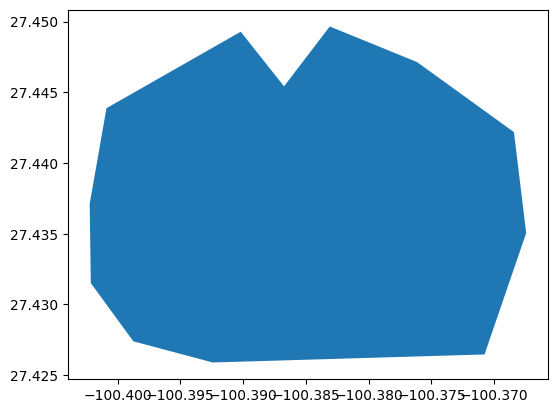

In [3]:
#Load data
presa_original = gpd.read_file("../../../data/external/temporal_todocker/{}.gpkg".format(city))
presa_original.plot()

Area of interest treatment

In [4]:
#Filter for relevant data
columns_tokeep = ['Name','geometry']
presa = presa_original[columns_tokeep]

#Create buffer for dam geometry
polygon = presa.to_crs("EPSG:6372").buffer(500)
polygon = polygon.to_crs("EPSG:4326")
polygon = gpd.GeoDataFrame(geometry=polygon).dissolve().geometry

#Review result
print(polygon.shape)
polygon.head(2)

(1,)


0    POLYGON ((-100.39270 27.45322, -100.39224 27.4...
Name: geometry, dtype: geometry

### Data download - Download and proccess rasters

In [5]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a"):
#df_len = aup.download_raster_from_pc(polygon, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query = query, satellite = satellite)

## Debug paso por paso

In [6]:
#download_raster_from_pc(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a"):
gdf = polygon.copy()

In [8]:
poly = gdf.to_crs("EPSG:6372").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)

date_list = aup.available_datasets(items, satellite)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)

# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, 
                                       band_name_list, freq)
aup.available_data_check(df_len, missing_months) # test for missing months

print(missing_months)

1


In [9]:
# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, 
                                       band_name_list, freq)
pct_missing = round(missing_months/len(df_len),2)*100
pct_missing

8.0

In [10]:
df_len.head(10)

,year,month,data_id
0,2016,1,1
1,2016,2,1
2,2016,3,0
3,2016,4,1
4,2016,5,1
5,2016,6,1
6,2016,7,1
7,2016,8,1
8,2016,9,1
9,2016,10,1


In [11]:
# raster cropping with bounding box from earlier
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

In [12]:
# download raster data by month
df_len = aup.create_raster_by_month(
    df_len, index_analysis, city, tmp_dir,
    band_name_dict,date_list, gdf_raster_test,
    gdf_bb, area_of_interest, satellite, query=query)

 33%|█████████████████████████████████████████████████████████▎                                                                                                                  | 4/12 [31:59<1:02:04, 465.53s/it]ERROR 1: TIFFFillTile:Read error at row 3584, col 3584, tile 206; got 0 bytes, expected 350887
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: IReadBlock failed at X offset 8, Y offset 9: TIFFReadEncodedTile() failed.
 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 7/12 [1:16:20<1:03:23, 760.62s/it]ERROR 1: TIFFFillTile:Read error at row 2560, col 2560, tile 314; got 0 bytes, expected 370305
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: IReadBlock failed at X offset 6, Y offset 14: TIFFReadEncodedTile() failed.
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [14]:
df_len.head(13)

,Unnamed: 0,year,month,data_id,able_to_download
0,0,2016,1,0,0.0
1,1,2016,2,1,NaN
2,2,2016,3,0,NaN
3,3,2016,4,1,NaN
4,4,2016,5,0,0.0
5,5,2016,6,1,NaN
6,6,2016,7,1,NaN
7,7,2016,8,0,0.0
8,8,2016,9,1,NaN
9,9,2016,10,1,NaN


### Inicia debug de Create raster by month

In [12]:
df_len['able_to_download'] = np.nan
band_name_list = list(band_name_dict.keys())[:-1]

In [14]:
# check if file exists, for example in case of code crash
df_file_dir = tmp_dir+index_analysis+f'_{city}_dataframe.csv'
if os.path.exists(df_file_dir) == False: # Or folder, will return true or false
    df_len.to_csv(df_file_dir)
# create folder to store temporary raster files by iteration
tmp_raster_dir = tmp_dir+'temporary_files/'
if os.path.exists(tmp_raster_dir) == False: # Or folder, will return true or false
    os.mkdir(tmp_raster_dir)

In [37]:
from tqdm import tqdm
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.fill import fillnodata
from pystac.extensions.eo import EOExtension as eo
from datetime import datetime
from dateutil.relativedelta import relativedelta
import planetary_computer as pc
from scipy import stats as st
from rasterio.merge import merge
import pandas as pd
import numpy as np
from func_timeout import func_timeout
import pymannkendall as mk
import scipy.ndimage as ndimage
from pystac_client import Client
from multiprocessing import Pool

In [41]:
aoi = area_of_interest
sat = satellite
time_exc_limit=1500

trial_list = [0]

#for i in tqdm(range(len(df_len)), position=0, leave=True):
for i in trial_list:
    
    df_raster = pd.read_csv(df_file_dir, index_col=False)

    # binary id - checks if month could be processed
    checker = 0
    
    #--------------------------------------------------------------------SÍ SE PASA A LA SIGUIENTE FECHA SI EL DATA_ID==0
    if df_raster.iloc[i].data_id==0:
        continue
       
    # gather month and year from df to save ndmi
    month_ = df_raster.loc[df_raster.index==i].month.values[0]
    year_ = df_raster.loc[df_raster.index==i].year.values[0]

    if f'{city}_{index_analysis}_{month_}_{year_}.tif' in os.listdir(tmp_dir):
        continue

    print(f'\n Starting new analysis for {month_}/{year_}')
    
    # gather links for raster images
    sample_date = datetime(year_, month_, 1)
    first_day = sample_date + relativedelta(day=1)
    last_day = sample_date + relativedelta(day=31)

    # creates time range for a specific month
    time_of_interest = [f"{year_}-{month_:02d}-{first_day.day:02d}/{year_}"+
                        f"-{month_:02d}-{last_day.day:02d}"]
    # gather links for the date range
    items = aup.gather_items(time_of_interest, aoi, query=query, satellite=sat)

    # gather links from dates that are within date_list
    assets_hrefs = aup.link_dict(band_name_list, items, date_list)
    # create dataframe
    #df_links = pd.DataFrame.from_dict(assets_hrefs, 
    #                                orient='Index').reset_index().rename(columns={'index':'date'})

    # dates according to cloud coverage
    date_order = [True if (d.month == month_) and (d.year == year_) else False for d in date_list]
    date_array = np.array(date_list)
    date_filter = np.array(date_order)
    dates_ordered = date_array[date_filter]

    # mosaic raster

    iter_count = 1

    while iter_count <= 5:

        # create skip date list used to analyze null values in raster
        skip_date_list = []

        #for data_link in range(len(df_links)):
        for data_link in range(len(dates_ordered)):
            print(f'Mosaic date {dates_ordered[data_link].day}'+
                        f'/{dates_ordered[data_link].month}'+
                        f'/{dates_ordered[data_link].year} - iteration:{iter_count}')

            # check if date contains null values within study area
            #if df_links.iloc[data_link]['date'] in skip_date_list:
            if dates_ordered[data_link] in skip_date_list:
                continue

            try:
                #links_band_1 = df_links.iloc[data_link][list(band_name_dict.keys())[0]]
                #links_band_2 = df_links.iloc[data_link][list(band_name_dict.keys())[1]]
                bands_links = assets_hrefs[dates_ordered[data_link]]

                rasters_arrays = func_timeout(time_exc_limit, aup.mosaic_process_v2,
                                                                            args=(bands_links,
                                                                                  band_name_dict, gdf_bb, tmp_raster_dir))
                out_meta = rasters_arrays[list(rasters_arrays.keys())[0]][2]

                # calculate raster index
                raster_idx = aup.calculate_raster_index(band_name_dict, rasters_arrays)
                log(f'Calculated {index_analysis}')
                del rasters_arrays

                print(f'Starting interpolation')

                raster_idx[raster_idx == 0 ] = np.nan # change zero values to nan
                raster_idx = raster_idx.astype('float32') # change data type to float32 to avoid fillnodata error

                print(f'Interpolating {np.isnan(raster_idx).sum()} nan values')
                raster_fill = fillnodata(raster_idx, mask=~np.isnan(raster_idx),
                                    max_search_distance=50, smoothing_iterations=0)
                print(f'Finished interpolation to fill na - {np.isnan(raster_fill).sum()} nan')

                with rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif",'w', **out_meta) as dest:
                        dest.write(raster_fill)

                        dest.close()

                print('Starting null test')

                raster_file = rasterio.open(f"{tmp_raster_dir}{index_analysis}.tif")

                gdf_raster_test = gdf_raster_test.to_crs(raster_file.crs)

                try:
                    # test for nan values within study area
                    raster_nan_test(gdf_raster_test,raster_file)

                    print('Passed null test')

                    # save raster to processing database
                    with rasterio.open(f"{tmp_dir}{city}_{index_analysis}_{month_}_{year_}.tif",'w', **out_meta) as dest:
                        dest.write(raster_fill)

                        dest.close()
                    print(f'Finished saving {index_analysis} raster')

                    checker = 1
                    iter_count = 6
                    aup.delete_files_from_folder(tmp_raster_dir)
                    break
                except:
                    print('Failed null test')
                    skip_date_list.append(assets_hrefs[list(assets_hrefs.keys())[data_link]])
                    aup.delete_files_from_folder(tmp_raster_dir)

            except:
                print(f'Error in iteration {iter_count}')
                aup.delete_files_from_folder(tmp_raster_dir)
                print(checker)
                continue
        iter_count = iter_count + 1

    if checker==0:
        df_raster.loc[df_raster.index==i,'data_id']=0
        df_raster.loc[df_raster.index==i,'able_to_download']=0
        df_raster.to_csv(df_file_dir, index=False)
        continue

return df_len


 Starting new analysis for 1/2016
Mosaic date 16/1/2016 - iteration:1
Error in iteration 1
0
Mosaic date 16/1/2016 - iteration:2
Error in iteration 2
0
Mosaic date 16/1/2016 - iteration:3
Error in iteration 3
0
Mosaic date 16/1/2016 - iteration:4
Error in iteration 4
0
Mosaic date 16/1/2016 - iteration:5
Error in iteration 5
0


SyntaxError: 'return' outside function (3634007360.py, line 142)

In [42]:
df_raster

,Unnamed: 0,year,month,data_id,able_to_download
0,0,2016,1,0,0.0
1,1,2016,2,1,NaN
2,2,2016,3,0,NaN
3,3,2016,4,1,NaN
4,4,2016,5,1,NaN
...,...,...,...,...,...
87,87,2023,4,1,NaN
88,88,2023,5,1,NaN
89,89,2023,6,1,NaN
90,90,2023,7,1,NaN


### Termina debug de Create raster by month

In [ ]:
missing_months = len(df_len.loc[df_len.data_id==0])
missing_months

In [ ]:
df_len

In [ ]:
#DEBUG STRATEGY ACCORDING TO ERROR IN aup.raster_interpolation: 
#Allow interpolation in not-found rasters.
#------------------------------------PRESA EL CUCHILLO
#df_len.loc[4,'data_id'] = 0 #05/2016
#df_len.loc[10,'data_id'] = 0 #11/2016
#df_len.loc[17,'data_id'] = 0 #6/2017
#df_len.loc[24,'data_id'] = 0 #1/2018
#df_len.loc[29,'data_id'] = 0 #6/2018
#df_len.loc[39,'data_id'] = 0 #4/2019
#df_len.loc[48,'data_id'] = 0 #1/2020
#df_len.loc[81,'data_id'] = 0 #10/2022
#------------------------------------PRESA LA BOCA
#df_len.loc[87,'data_id'] = 0 #4/2023

In [16]:
df_len = aup.raster_interpolation(df_len, city, tmp_dir, index_analysis)

In [17]:
missing_months = len(df_len.loc[df_len.data_id==0])
missing_months

0

## End of debug

### Data download - Create hexgrid from area of interest

In [6]:
hex_gdf = gpd.GeoDataFrame(polygon)
hex_gdf['res'] = res[0]

if len(res)>1:
#If there is more than one resolution
    for r in range(res[0]+1,res[-1]+1): #Skips res 8 because, originally, res 8 is already in original hex_gdf
        hex_tmp = aup.create_hexgrid(polygon, r)
        hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
        hex_tmp['res'] = r
        hex_gdf = pd.concat([hex_gdf, hex_tmp],ignore_index = True, axis = 0)
        del hex_tmp

#If there is only one resolution
else:
    hex_gdf = aup.create_hexgrid(hex_gdf, res[0])
    hex_gdf.rename(columns={f'hex_id_{res[0]}':'hex_id'}, inplace=True)
    hex_gdf['res'] = res[0]
    
#Show
print(hex_gdf.shape)
hex_gdf.head(2)

(132098, 3)


,hex_id,geometry,res
0,8c48b5149d749ff,"POLYGON ((-99.41748 24.90971, -99.41738 24.909...",12
1,8c48b5a9648c3ff,"POLYGON ((-99.40471 24.94664, -99.40461 24.946...",12


## Data processing

### Data processing - Raster to hex

In [7]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)

    if save:
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

In [35]:
for r in list(hex_gdf.res.unique()):

    processing_chunk = 150000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)
    
    if len(hex_gdf_res)>processing_chunk:
        c_processing = len(hex_gdf_res)/processing_chunk
        
        for i in range(int(c_processing)):
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)
    else:
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

 12%|███████████████████▏                                                                                                                                     | 1/8 [11:31<1:20:38, 691.24s/it]

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 3/8 [35:29<59:37, 715.50s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 5/8 [1:10:54<48:31, 970.41s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 7/8 [1:39:03<14:43, 883.76s/it]

  0%|                                                                                                                                                                                        | 0/8 [06:36<?, ?it/s]


## Data save

In [ ]:
# local save
if save:
    hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_.geojson')
    df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_.csv')